## ✒️ Code Modules & Settings

In [1]:
import os,io,pathlib,pylab as pl
import scipy.misc,numpy as np
from six import BytesIO
from PIL import Image,ImageDraw,ImageFont
from six.moves.urllib.request import urlopen
import tensorflow as tf,tensorflow_hub as hub
tf.get_logger().setLevel('ERROR')

In [2]:
!git clone --depth 1 https://github.com/tensorflow/models --quiet

In [3]:
%%bash
sudo apt install -y protobuf-compiler --quiet
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install . --quiet

bash: line 1: sudo: command not found
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.2.7 requires dill>=0.3.3, but you have dill 0.3.1.1 which is incompatible.
multiprocess 0.70.11.1 requires dill>=0.3.3, but you have dill 0.3.1.1 which is incompatible.
earthengine-api 0.1.248 requires google-api-python-client>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
autogluon-core 0.0.16b20210126 requires dill==0.3.3, but you have dill 0.3.1.1 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


## ✒️ Models

In [4]:
from object_detection.utils import \
label_map_util,ops as utils_ops,\
visualization_utils as viz_utils
PATH_TO_LABELS='./models/research/object_detection/'+\
               'data/mscoco_label_map.pbtxt'
category_index=label_map_util\
.create_category_index_from_labelmap(
    PATH_TO_LABELS,use_display_name=True)

In [5]:
ALL_MODELS={
'CenterNet HourGlass104 512x512':
    'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512':
    'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024':
    'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024':
    'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512':
    'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512':
    'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512':
    'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512':
    'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512':
    'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512':
    'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640':
    'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768':
    'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896':
    'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024':
    'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280':
    'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280':
    'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536':
    'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320':
    'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640':
    'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320':
    'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640':
    'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)':
    'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)':
    'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)':
    'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)':
    'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)':
    'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)':
    'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640':
    'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024':
    'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024':
    'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'}

In [6]:
model_display_name='CenterNet HourGlass104 1024x1024'
#'CenterNet Resnet50 V2 Keypoints 512x512'
model_handle=ALL_MODELS[model_display_name]
print('Selected model:'+model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))
print('loading model...')
hub_model=hub.load(model_handle)
print('model loaded!')

Selected model:CenterNet HourGlass104 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1
loading model...
model loaded!


## ✒️ Images

In [7]:
def load_image_into_numpy_array(path):
    image=None
    if(path.startswith('http')):
        response=urlopen(path)
        image_data=response.read()
        image_data=BytesIO(image_data)
        image=Image.open(image_data)
    else:
        image_data=tf.io.gfile.GFile(path,'rb').read()
        image=Image.open(BytesIO(image_data))
    (im_width,im_height)=image.size
    return np.array(image.getdata()).reshape(
        (1,im_height,im_width,3)).astype(np.uint8)
%matplotlib inline

In [8]:
COCO17_HUMAN_POSE_KEYPOINTS=\
[(0,1),(0,2),(1,3),(2,4),(0,5),(0,6),
 (5,7),(7,9),(6,8),(8,10),(5,6),(5,11),
 (6,12),(11,12),(11,13),(13,15),(12,14),(14,16)]

In [9]:
file_path='https://olgabelitskaya.gitlab.io/images/'
images_dict={
    'squirrel':file_path+'01_024.png',
    'night lights':file_path+'01_026.png',
    'ducks':file_path+'01_027.png',
    'science lesson':file_path+'01_028.png',
    'insects':file_path+'01_029.png'
}

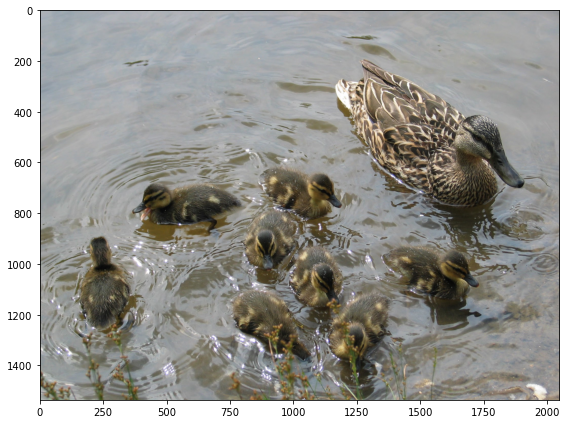

In [10]:
selected_img='ducks'
flip_image_horizontally=False
convert_image_to_grayscale=False
rotate_image_90=0
img_path=images_dict[selected_img]
img_np=load_image_into_numpy_array(img_path)
if (flip_image_horizontally):
    img_np[0]=np.fliplr(img_np[0]).copy()
if (convert_image_to_grayscale):
    img_np[0]=np.tile(
        np.mean(img_np[0],2,keepdims=True),(1,1,3))\
    .astype(np.uint8)
for i in range(rotate_image_90):
    img_np=tf.image.rot90(img_np).numpy().copy()
pl.figure(figsize=(8,12))
pl.imshow(img_np[0])
pl.tight_layout(); pl.show()

## ✒️ Object Detection

In [11]:
results=hub_model(img_np)
result={key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['num_detections', 'detection_classes', 'detection_boxes', 'detection_scores'])


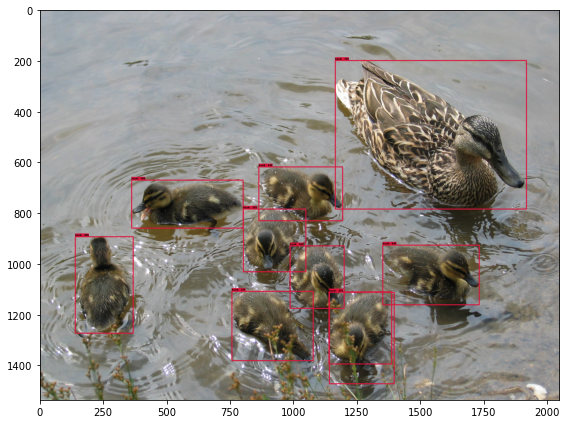

In [12]:
label_id_offset=0
img_np_detections=img_np.copy()
keypoints,keypoint_scores=None,None
if 'detection_keypoints' in result:
    keypoints=result['detection_keypoints'][0]
    keypoint_scores=result['detection_keypoint_scores'][0]
viz_utils.visualize_boxes_and_labels_on_image_array(
      img_np_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0]+\
       label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.2,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)
pl.figure(figsize=(8,12))
pl.imshow(img_np_detections[0])
pl.tight_layout(); pl.show()

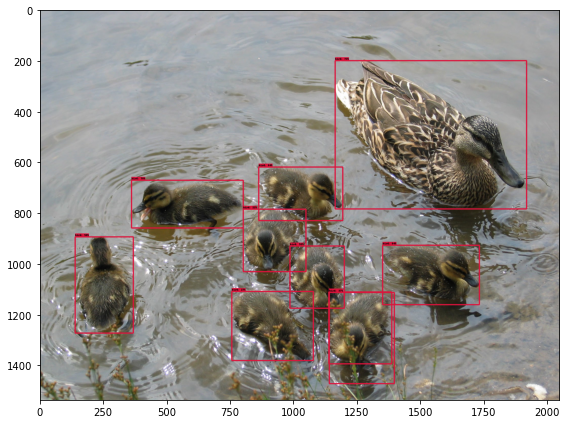

In [13]:
img_np_mask=img_np.copy()
if 'detection_masks' in result:
    detection_masks=tf.convert_to_tensor(result['detection_masks'][0])
    detection_boxes=tf.convert_to_tensor(result['detection_boxes'][0])
    detection_masks_reframed=\
    utils_ops.reframe_box_masks_to_image_masks(
        detection_masks, detection_boxes,
        img_np.shape[1],img_np.shape[2])
    detection_masks_reframed=\
    tf.cast(detection_masks_reframed>.5,tf.uint8)
    result['detection_masks_reframed']=detection_masks_reframed.numpy()
viz_utils.visualize_boxes_and_labels_on_image_array(
      img_np_mask[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0]+label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=.2,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed',None),
      line_thickness=5)
pl.figure(figsize=(8,12))
pl.imshow(img_np_mask[0])
pl.tight_layout(); pl.show()